In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('data/names.txt', 'r').read().splitlines()

In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0]*block_size
        for char in word + '.' :
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
        

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [ ]:
n_embd = 10
n_hidden = 200


C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(block_size*n_embd, n_hidden) * 0.2
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden, vocab_size) * 0.1
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
max_steps = 200000
lossi = []
batch_size = 32

for i in range(max_steps):
    # minibatch construct
    ix  = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * ((hpreact - hpreact.mean(0, keepdims=True))  / hpreact.std(0, keepdims=True)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/200000: 3.4894
  10000/200000: 1.8683
  20000/200000: 2.1329
  30000/200000: 2.2709
  40000/200000: 2.2380
  50000/200000: 2.0254
  60000/200000: 1.9735
  70000/200000: 2.1394
  80000/200000: 2.1356
  90000/200000: 1.9591
 100000/200000: 2.0552
 110000/200000: 1.9357
 120000/200000: 1.7466
 130000/200000: 2.3642
 140000/200000: 2.0255
 150000/200000: 2.0405
 160000/200000: 1.9729
 170000/200000: 2.1847
 180000/200000: 2.0264
 190000/200000: 1.9464


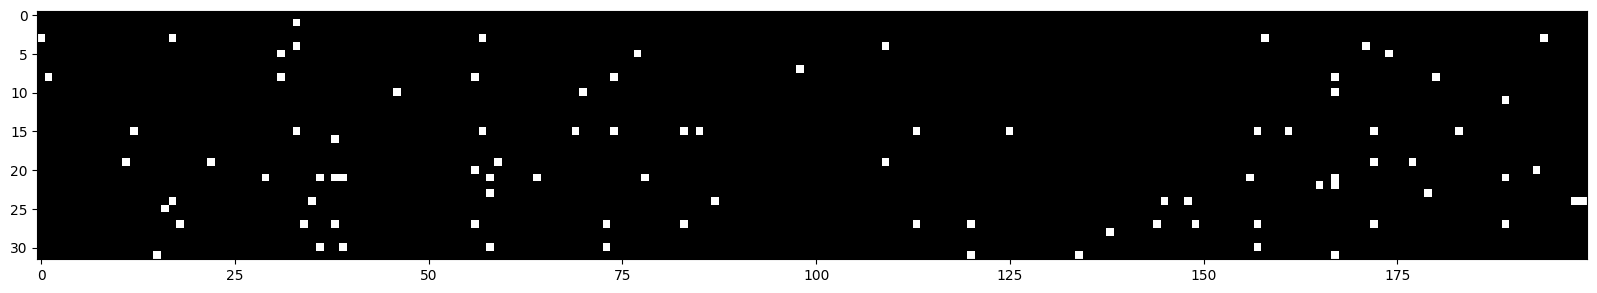

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

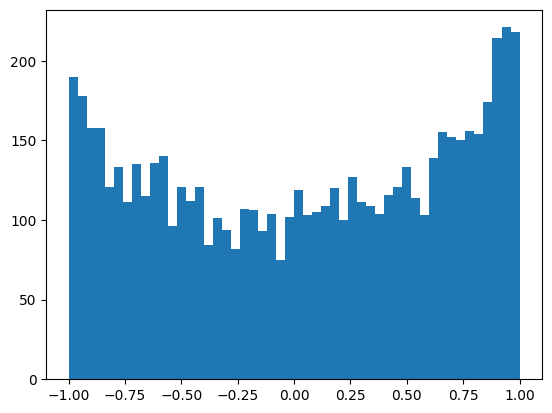

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

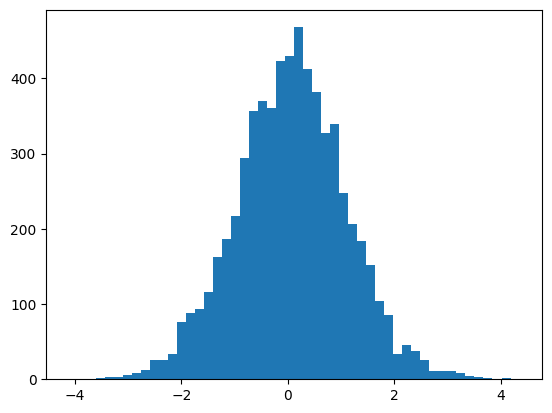

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

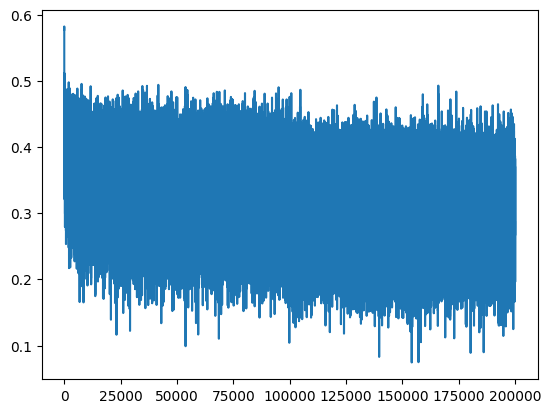

In [ ]:
plt.plot(lossi);

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * ((hpreact - hpreact.mean(0, keepdims=True))  / hpreact.std(0, keepdims=True)) + bnbias
    h =  torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.064197301864624
val 2.1247751712799072


tensor(0.0003) tensor(1.0045)
tensor(-0.0006) tensor(0.9971)


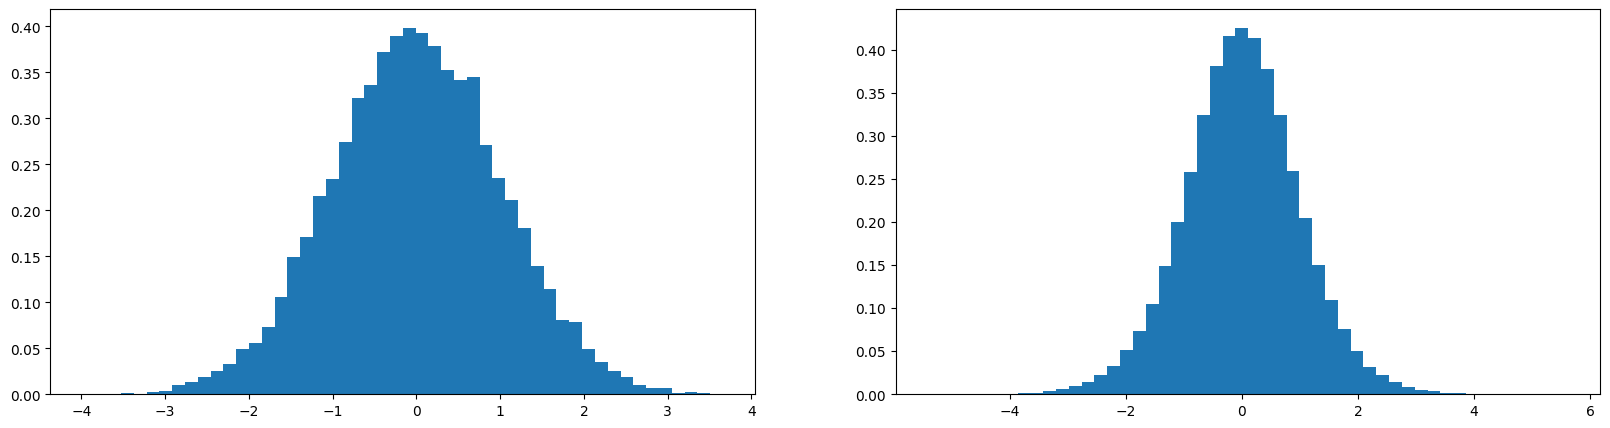

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.w = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias is not None else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.w] + ([] if self.bias is None else [self.bias])



class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum )*self.running_mean + self.momentum *xmean
                self.running_var = (1-self.momentum )*self.running_var + self.momentum *xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100

C = torch.randn(vocab_size, n_embd)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),  BatchNorm1D(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),  BatchNorm1D(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),  BatchNorm1D(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb, yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).mean().log10().item() for p in parameters])

    if i > 1000:
        break

      0/ 200000: 3.3158


layer 1 (      Tanh): mean +0.04 std 0.79 saturated: 26.03%
layer 4 (      Tanh): mean -0.00 std 0.64 saturated: 2.84%
layer 7 (      Tanh): mean +0.00 std 0.64 saturated: 2.06%
layer 10 (      Tanh): mean -0.00 std 0.65 saturated: 2.41%
layer 13 (      Tanh): mean -0.00 std 0.65 saturated: 1.53%


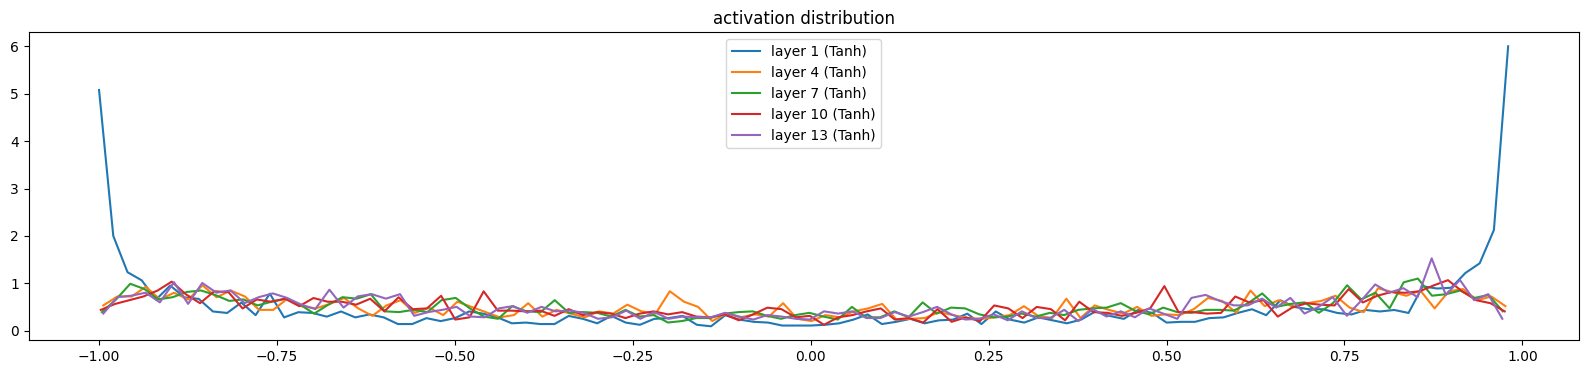

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f std %.2f saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution');

layer 1 (      Tanh): mean +0.00 std 3.120727e-03 saturated: 0.00%
layer 4 (      Tanh): mean -0.00 std 2.821662e-03 saturated: 0.00%
layer 7 (      Tanh): mean -0.00 std 2.573311e-03 saturated: 0.00%
layer 10 (      Tanh): mean -0.00 std 2.347920e-03 saturated: 0.00%
layer 13 (      Tanh): mean +0.00 std 2.258618e-03 saturated: 0.00%


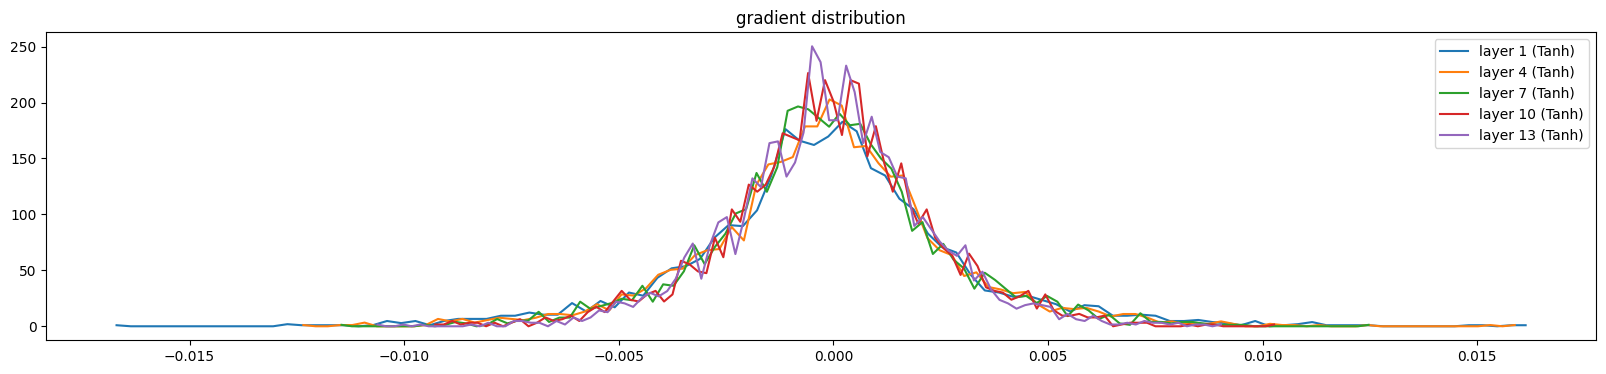

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f std %e saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution');

weight 0 torch.Size([27, 10]): mean  -0.000026  std 9.197699e-03 grad:data ratio: 8.962445e-03
weight 1 torch.Size([30, 100]): mean  -0.000029  std 7.929490e-03 grad:data ratio: 2.552780e-02
weight 3 torch.Size([100, 100]): mean  +0.000025  std 6.554012e-03 grad:data ratio: 3.949221e-02
weight 7 torch.Size([100, 100]): mean  +0.000020  std 5.382780e-03 grad:data ratio: 3.219647e-02
weight 11 torch.Size([100, 100]): mean  +0.000044  std 4.991753e-03 grad:data ratio: 2.995519e-02
weight 15 torch.Size([100, 100]): mean  +0.000003  std 4.290950e-03 grad:data ratio: 2.550059e-02
weight 19 torch.Size([100, 27]): mean  +0.000154  std 8.067382e-03 grad:data ratio: 4.805385e-02


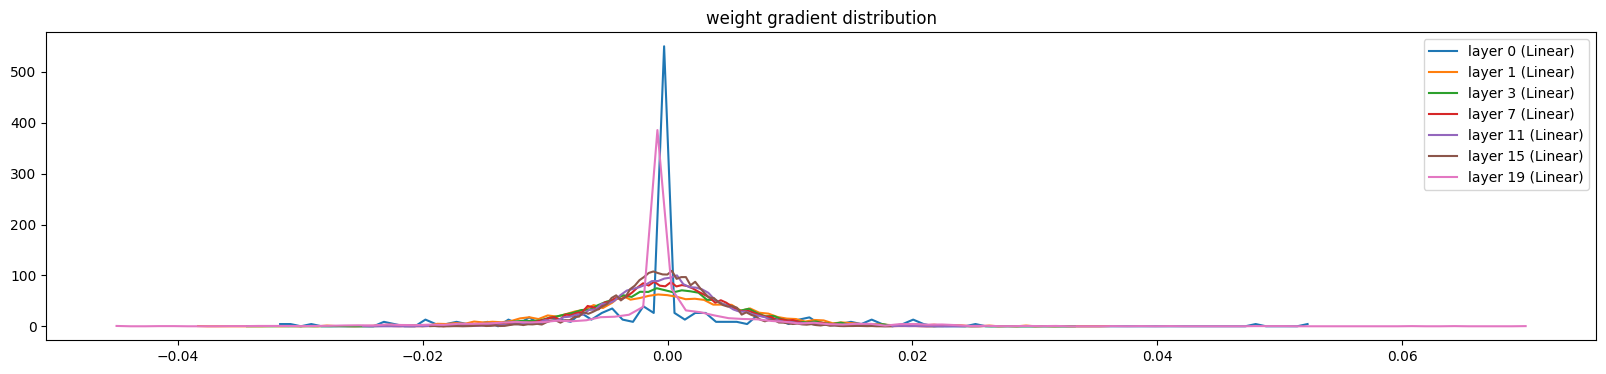

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print('weight %d %10s: mean  %+f  std %e grad:data ratio: %e' % (i, p.shape , t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weight gradient distribution');

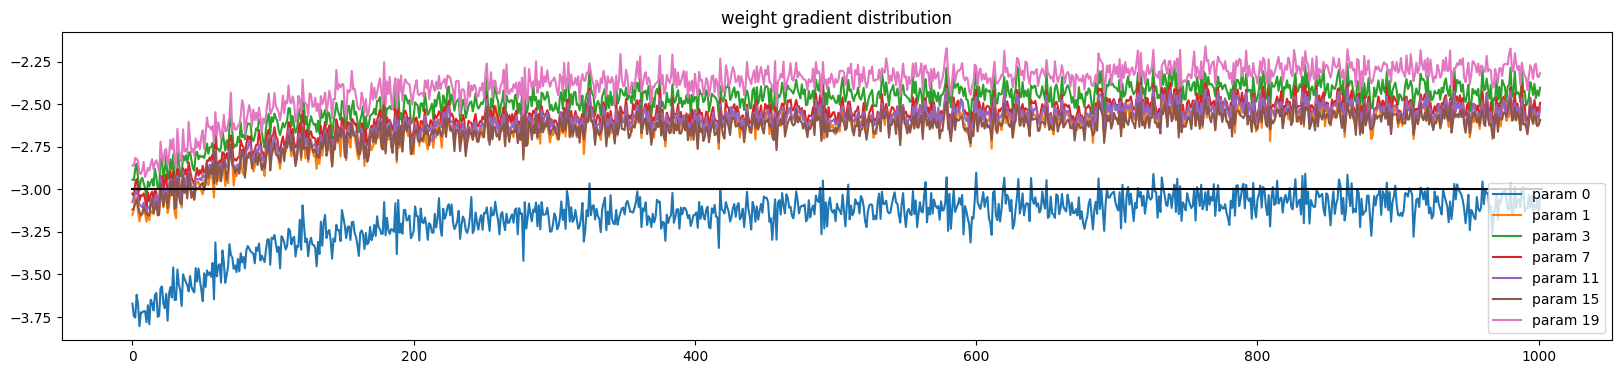

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('weight gradient distribution');